<a href="https://colab.research.google.com/github/hkaragah/google_colab_repo/blob/main/hands_on_ml_exercises/06_Overfitted_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overfitting in Decision Tree: Moons Dataset

__Disclaimer:__ This exercise is adopted from `"Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow (Third Edition)"` book written by `_Aurelien Geron_` publoshed by `_O'Reilly_`. I broke them down into smaller digestable snippets, made some modifications, and added some explanations so that I can undersatand them better. The porpuse of this notebook is just for me to understand the concept and have hands-on practice while reading the book material.

## Objective
Apply decision tree method to _moon_ dataset, and explore the effect of hyperparameters in overfitting the model

## Load Dataset

In [2]:
from sklearn.datasets import make_moons
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from graphviz import Source
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [3]:
X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

print(f"Feature shape: {X_moons.shape}")
print(f"Target shape: {y_moons.shape}")

Feature shape: (150, 2)
Target shape: (150,)


## Define and Train Model

To explore the effect of hyperparameters, I define two classifiers with different hyperparameters.

In [4]:
tree_clf1 = DecisionTreeClassifier(random_state=42) # no contraint, the algorithm makes decision about the tree configs
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf3 = DecisionTreeClassifier(max_leaf_nodes=5, random_state=42)

tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)
tree_clf3.fit(X_moons, y_moons)

DecisionTreeClassifier(max_leaf_nodes=5, random_state=42)

## Visualization

In [5]:
def plot_tree(tree_clf, size):
    # Create and export .dot file
    export_graphviz(
            tree_clf,
            out_file= 'file.dot',
            # feature_names=iris.feature_names[2:],
            # class_names=iris.target_names,
            rounded=True,
            filled=True)

    # Read the .dot file into a string
    with open('file.dot', 'r') as file:
        dot_data = file.read()

    # Insert the size attribute into the string
    dot_data = dot_data.replace('digraph Tree {', f'digraph Tree {{\ngraph [size="{size}"];')

    # Create a Source object from the modified string
    src = Source(dot_data)

    # Display .dot file
    return src

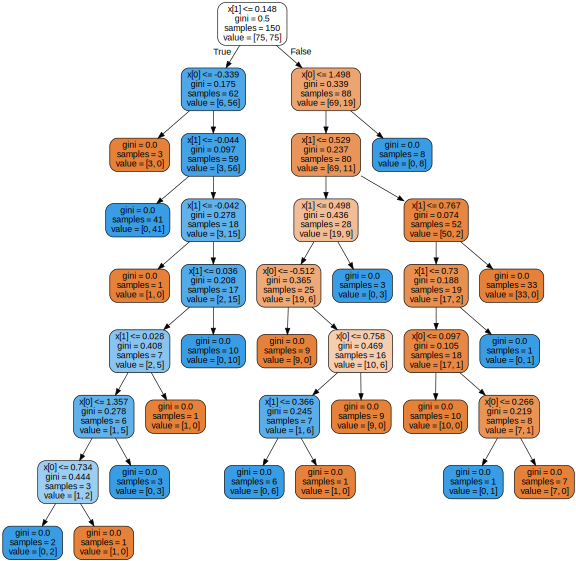

In [6]:
plot_tree(tree_clf1, size="8,8!")


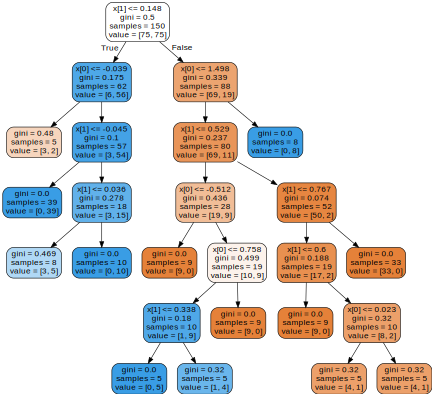

In [7]:
plot_tree(tree_clf2, size="6,6!")

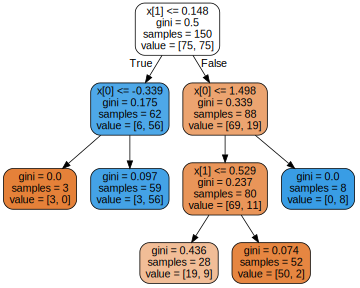

In [8]:
plot_tree(tree_clf3, size="5,5!")

It seems, the first model, that hasnot ctraints, split the nodes until it reaches to leaf nodes with _gini_ value of zero. However, that's not the case with the other two models, and the specified hyperparameters, `max_depth=3` for `tree_clf2` and `max_leaf_nodes=5` for `tree_clf3` made the model stop earlier.
The depth in `tree_clf2` is in fact 3, and in `tree_clf3` the number of leaf nodes is 5 which is the maximum specified value.

In [43]:
def generate_meshgrid(X, n):

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, n),
                         np.linspace(x2_min, x2_max, n))
    return x1, x2


def plot_decision_boundary(clf, X, y, ax, cmap):
    n = 100
    x1, x2 = generate_meshgrid(X, n) # x1 and x2 are of shape (n, n)

    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#DEF9C4', '#9CDBA6', '#468585'])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap) # field
    ax.contour(x1, x2, y_pred, cmap="crest", linewidths=[0.5,0.5,0.5], alpha=0.8) # line


def plot_points(X, y, ax, styles, ax_labels, s=30, alpha=0.7):
    for i in range(len(styles)):
        # ax.plot(X[:, 0][y==i], X[:, 1][y==i], styles[i])
        sns.scatterplot(x=X[:, 0][y == i], y=X[:, 1][y == i], ax=ax, marker=styles[i][0], color=styles[i][1], s=s, edgecolor='k', alpha=alpha)

    ax.set_xlabel(ax_labels[0])
    ax.set_ylabel(ax_labels[1], rotation=0)

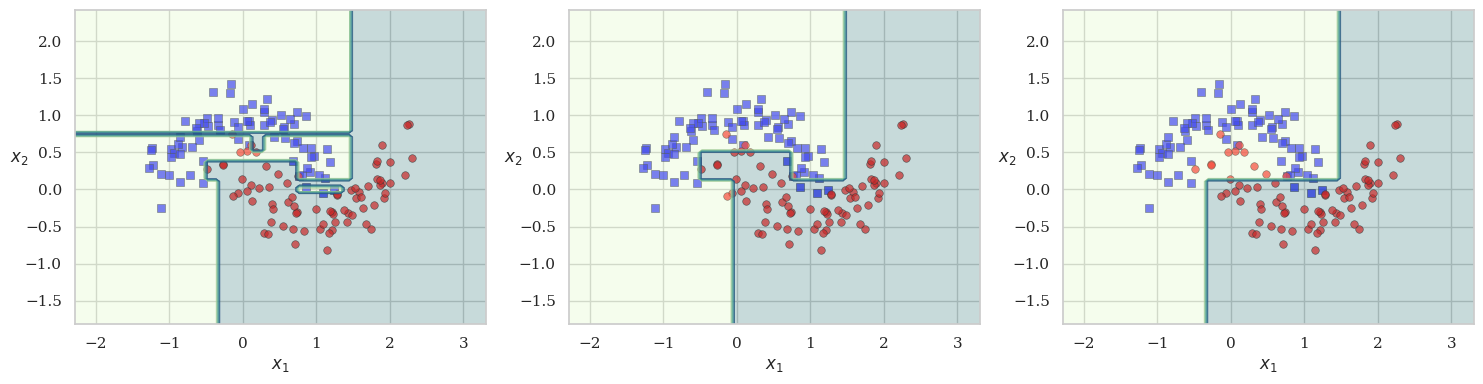

In [10]:
sns.set(style="whitegrid",       # Style of the plot; "darkgrid"
        context="notebook",        # Size of elements, "talk"
        palette="pastel",          # Color palette, "husl", "viridis"
        font="serif")              # Font family

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))


plot_points(X_moons, y_moons, axes[0], [("s", "blue"), ("o", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(tree_clf1, X_moons, y_moons, axes[0],cmap="Pastel1")

plot_points(X_moons, y_moons, axes[1], [("s", "blue"), ("o", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(tree_clf2, X_moons, y_moons, axes[1], cmap="Pastel1")

plot_points(X_moons, y_moons, axes[2], [("s", "blue"), ("o", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(tree_clf3, X_moons, y_moons, axes[2], cmap="Pastel1")

plt.tight_layout()
plt.show()

It is evident that the model with no hyperparameter is hight overfitted. Let's compute the score of each model on a new moon dataset.

In [11]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=43)

print(f"tree_clf1 score: {tree_clf1.score(X_moons_test, y_moons_test)}")
print(f"tree_clf2 score: {tree_clf2.score(X_moons_test, y_moons_test)}")
print(f"tree_clf3 score: {tree_clf3.score(X_moons_test, y_moons_test)}")

tree_clf1 score: 0.898
tree_clf2 score: 0.92
tree_clf3 score: 0.914


In [12]:
tree_clf2.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In fact, the first model is overfitted.

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_leaf_nodes': np.arange(2,20,1),
     'min_samples_split': np.arange(2,100,10),
     'min_samples_leaf': np.arange(2,100,10)}
]

X, y = make_moons(n_samples=150, noise=0.2, random_state=42)

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, refit=True)
grid_search.fit(X_moons, y_moons)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                          'min_samples_leaf': array([ 2, 12, 22, 32, 42, 52, 62, 72, 82, 92]),
                          'min_samples_split': array([ 2, 12, 22, 32, 42, 52, 62, 72, 82, 92])}])

In [31]:
grid_search.best_params_

{'max_leaf_nodes': 11, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [32]:
grid_search.best_estimator_.score(X_moons_test, y_moons_test)

0.909

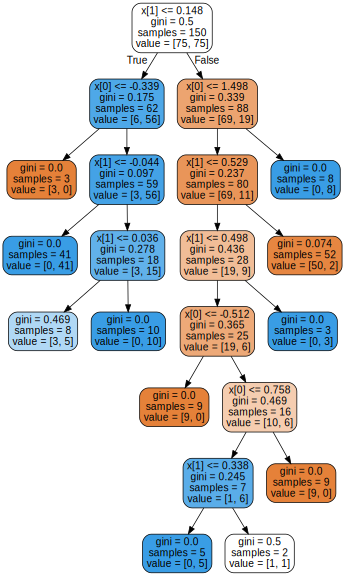

In [34]:
plot_tree(grid_search.best_estimator_, size="8,8!")

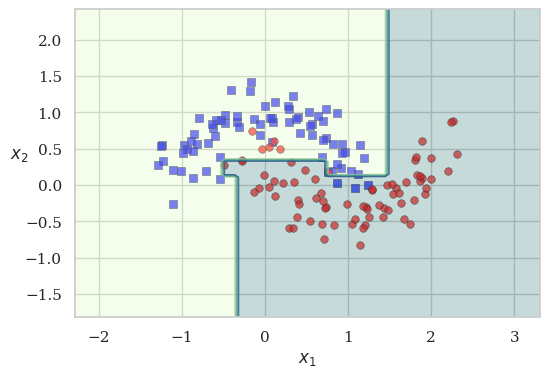

In [35]:
plt.figure(figsize=(6, 4))

plot_points(X, y, ax=plt.gca(), styles=[("s", "blue"), ("o", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(grid_search.best_estimator_, X, y, ax=plt.gca(), cmap="Pastel1")

plt.show()

## Chapter Exercise #7

In [36]:
X, y = make_moons(n_samples=10_000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42) # Default 25%

param_grid = [{
    'max_leaf_nodes': np.arange(2,20,1)
}]

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, refit=True)
grid_search.fit(X_train, y_train)

print(f"Best model: {grid_search.best_estimator_}")
print(f"Best score: {grid_search.best_estimator_.score(X_test, y_test)}")

Best model: DecisionTreeClassifier(max_leaf_nodes=18, random_state=42)
Best score: 0.9668


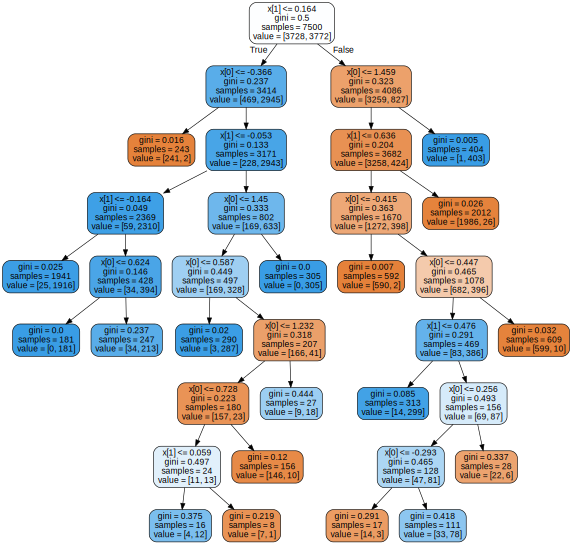

In [37]:
plot_tree(grid_search.best_estimator_, size="8,8!")

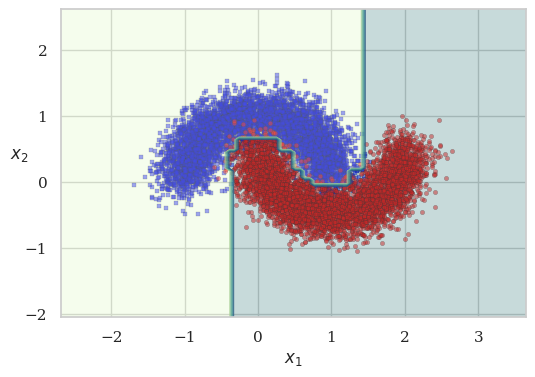

In [45]:
plt.figure(figsize=(6, 4))

plot_points(X, y, ax=plt.gca(), styles=[("s", "blue"), ("o", "red")], ax_labels=[r"$x_1$", r"$x_2$"], s=10, alpha=0.5)
plot_decision_boundary(grid_search.best_estimator_, X, y, ax=plt.gca(), cmap="Pastel1")

plt.show()

The boundary seems to follow the data points quite closely.